In [1]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 4.2 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=4e9aa547baed10d6310265ea56ad2adbbd258a89cf68fe4c7a588293a2e9d5f7
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control


In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
 
# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Semesterproject 1/Code/KalmanNet_control/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
 
# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [3]:
import torch

from systems import LinearSystem
from system_model_lqr import SystemModelLQR
from system_knet_linear import KalmanNetNN
from system_pipeline_simple import Pipeline_KF_simple
from Linear_KF import KalmanFilter
from KalmanFilter_test import KFTest
from Plot import Plot

from datetime import datetime
import matplotlib.pyplot as plt
import os
from math import log10, sin, cos, pi

Running on the CPU


In [4]:
#############
### Model ###
#############
dtype_ = torch.float32
q2 = 1  # process noise variance
r2 = 1   # observation noise variance
T = 50    # trajectory length / time horizon
q2_dB = 10*log10(q2)
r2_dB = 10*log10(r2)

# State and observation dynamics
F = torch.tensor([[1, 1], [0,  1]], dtype=dtype_)
G = torch.tensor([[0],[1]], dtype=dtype_)
H = torch.tensor([[1, 0], [0, 1]], dtype=dtype_)

m = F.size()[0] # state dim
p = G.size()[1] # input dim
n = H.size()[0] # output dim

# Process and measurement noise
Q = q2 * torch.eye(m, dtype=dtype_)
R = r2 *  torch.eye(n, dtype=dtype_)  

# Initial state
m1_0 = x0 = torch.tensor([10, 0], dtype=dtype_)
xT = torch.tensor([0, 0], dtype=dtype_)
m2_0 = 0.*torch.eye(m) # covariance of initial state

# LQR stuff: cost matrices
scale = 1
qT = 1
qx = 1
qu = 0.1
QT = qT * torch.eye(m, dtype=dtype_) * scale
Qx = qx * torch.eye(m, dtype=dtype_) * scale
Qu = qu * torch.eye(p, dtype=dtype_) * scale

# Prior covariances for KalmanNet architecture 2
prior_Q = 1 * torch.eye(m, dtype=dtype_)
prior_Sigma = 1 * torch.eye(m, dtype=dtype_)
prior_S = 1 * torch.eye(n, dtype=dtype_)

###################
### True System ###
###################
a_deg = 0
a = a_deg / 180 * pi
Rot = torch.tensor([[cos(a), -sin(a)], [sin(a),  cos(a)]])
trueF = torch.matmul(Rot, F)
trueG = G
trueH = H

# Create system
true_sys = LinearSystem(trueF, trueG, trueH, Q, R)

# Create model
sys_model = SystemModelLQR(F, G, q2, H, r2, T, T, true_sys, prior_Q, prior_Sigma, prior_S)
sys_model.InitCostMatrices(QT, Qx, Qu)
sys_model.InitSequence(m1_0, m2_0)


In [8]:
#################
### Set Paths ###
#################

# TODO: set correct paths for desired experiment

drive_knet = '/content/drive/MyDrive/Semesterproject 1/Code/KalmanNet_control/'
data_path = drive_knet + 'final_experiments/for_presentation/'
data = f'N_10000_2000_2000_T_{T}_q2_{int(q2_dB)}dB_r2_{int(r2_dB)}dB.pt'
noise_data = data_path + 'noise_' + data

models_folder = data_path + f'Test/'
model_name =  f'offline_T_{T}_noise_{int(r2_dB)}dB_reg_1e-3_lr_5e-4.pt'

y_u_x_data = data_path + 'y_u_x_no_control_' + data

# Make sure the folder already exists
error_message = f"The following directory does not exist:\n{models_folder}"
assert os.path.isdir(models_folder), error_message

# Remember to create a new name
warning = f"Model {model_name} already exists. If you continue, it will be overwritten."
assert not os.path.isfile(models_folder + 'model_' + model_name), warning

In [9]:
#################
### Load data ###
#################
training_data, validation_data, test_data, model_data = torch.load(y_u_x_data)

N_train = 1000
N_val = 100
N_test = 100

Y_train, U_train, X_train, X0_train = (D[:N_train] for D in training_data)

Y_val, U_val, X_val, X0_val = (D[:N_val] for D in validation_data)

Y_test, U_test, X_test, X0_test = (D[:N_test] for D in test_data)


train_input = (Y_train, U_train, X0_train)
train_target = X_train

val_input = (Y_val, U_val, X0_val)
val_target = X_val

test_input = (Y_test, U_test, X0_test)
test_target = X_test

In [10]:
##############################
### Evaluate Kalman Filter ###
##############################
[MSE_KF_total_arr, MSE_KF_total_dB_avg, MSE_KF_total_dB_std, MSE_KF_position_arr, MSE_KF_position_dB_avg, MSE_KF_position_dB_std] = KFTest(sys_model, test_input, test_target)

Kalman Filter - Total MSE LOSS: -1.90793 [dB], STD:  0.60836 [dB]
Kalman Filter - Position MSE LOSS: -1.51006 [dB], STD:  0.87724 [dB]
Inference Time: 0.5136346817016602


In [11]:
################
### Get Time ###
################
today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow

##################
###  KalmanNet ###
##################
KNet_Pipeline = Pipeline_KF_simple(strTime, models_folder, model_name)
KNet_Pipeline.setssModel(sys_model)
KNet_model = KalmanNetNN()
KNet_model.Build(sys_model)
KNet_Pipeline.setModel(KNet_model)
KNet_Pipeline.setTrainingParams(n_Epochs=100, n_Batch=16, learningRate=0.5E-3, weightDecay=1E-3)

#################
###  Training ###
#################
KNet_Pipeline.NNTrain(train_input, train_target, val_input, val_target, n_val=16,num_restarts=2)
MSE_test_total_arr, MSE_test_total_dB_avg, MSE_test_position_arr, MSE_test_position_dB_avg = KNet_Pipeline.NNTest(test_input, test_target)
KNet_Pipeline.save()

0 MSE train:  86.492111 [dB], MSE val:  41.570660 [dB], Optimal idx: 0, Optimal MSE val:  41.570660 [dB]
1 MSE train:  35.657619 [dB], MSE val:  22.010670 [dB], Optimal idx: 1, Optimal MSE val:  22.010670 [dB]
2 MSE train:  21.899862 [dB] MSE val:  18.612759 [dB], diff MSE val: -3.397911 [dB], Optimal idx: 2, Optimal MSE val:  18.612759 [dB]
3 MSE train:  17.677000 [dB] MSE val:  17.031769 [dB], diff MSE val: -1.580990 [dB], Optimal idx: 3, Optimal MSE val:  17.031769 [dB]
4 MSE train:  16.147465 [dB] MSE val:  16.027155 [dB], diff MSE val: -1.004614 [dB], Optimal idx: 4, Optimal MSE val:  16.027155 [dB]
5 MSE train:  15.518475 [dB] MSE val:  15.055227 [dB], diff MSE val: -0.971928 [dB], Optimal idx: 5, Optimal MSE val:  15.055227 [dB]
6 MSE train:  13.579245 [dB] MSE val:  14.301461 [dB], diff MSE val: -0.753766 [dB], Optimal idx: 6, Optimal MSE val:  14.301461 [dB]
7 MSE train:  12.939901 [dB] MSE val:  13.661789 [dB], diff MSE val: -0.639672 [dB], Optimal idx: 7, Optimal MSE val:  1

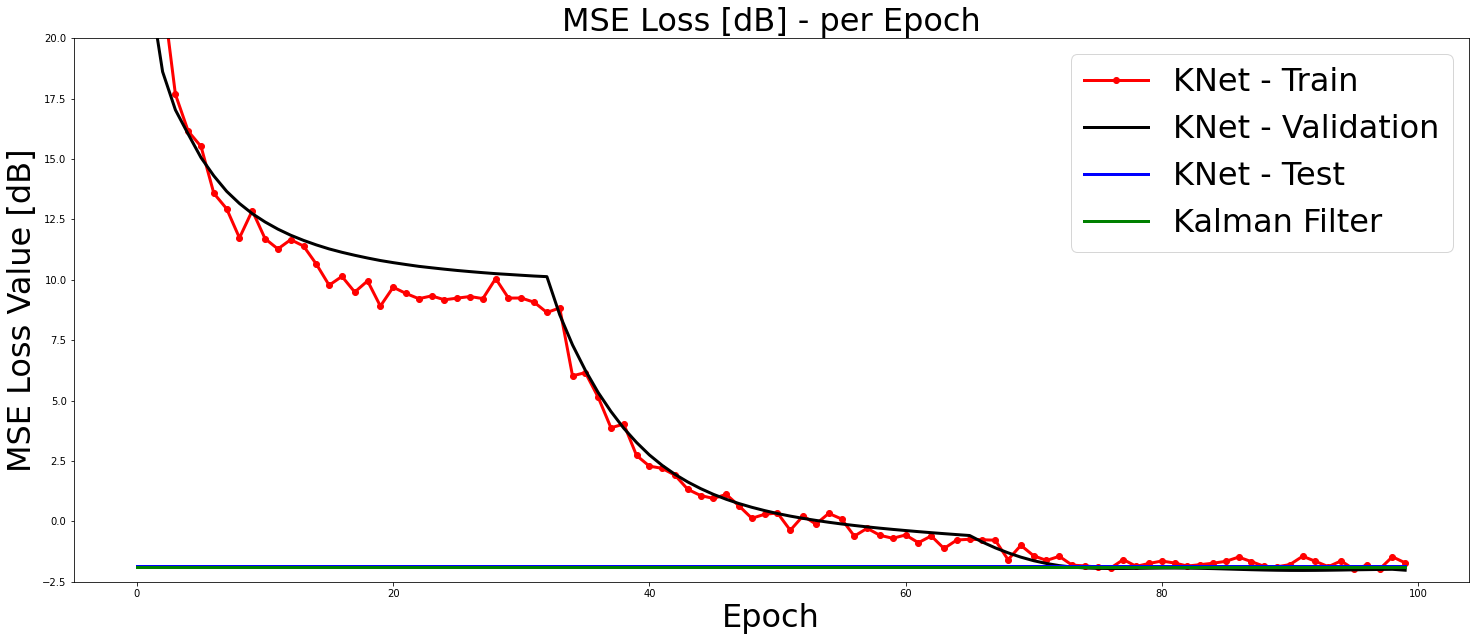

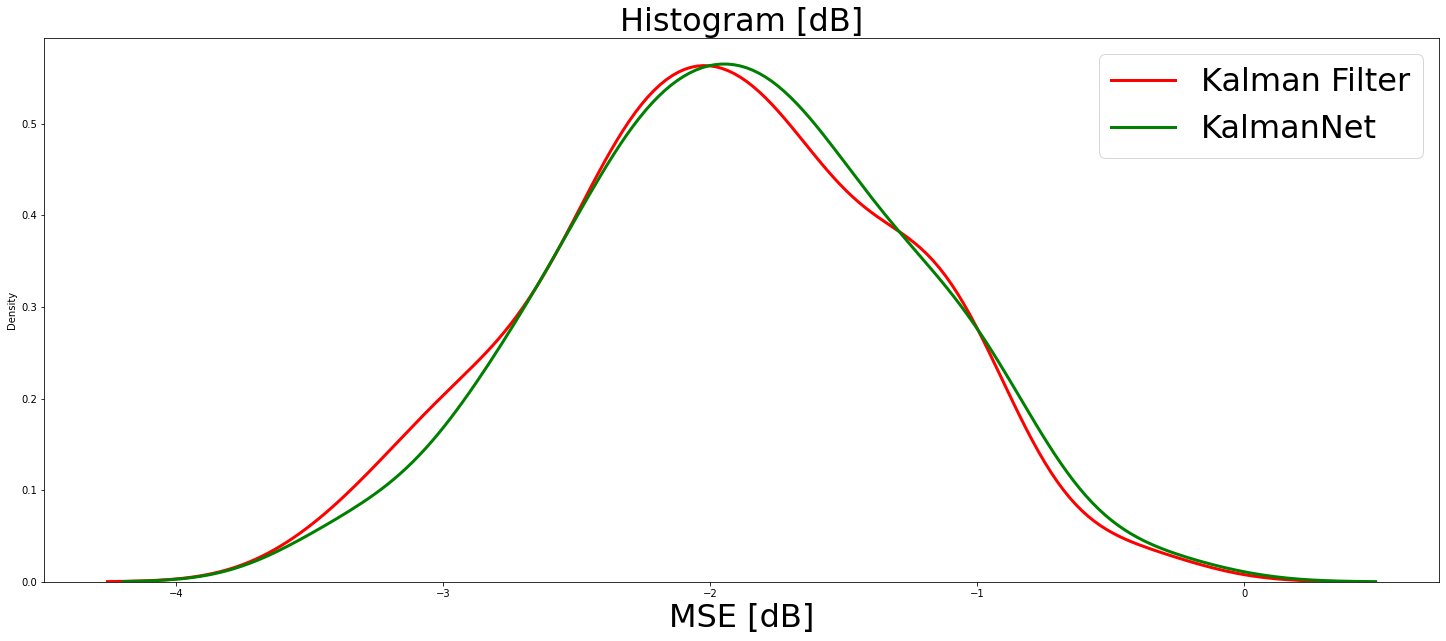

In [17]:
P = Plot(KNet_Pipeline)
P.plot_epochs_simple(lineWidth=3, title='', ylim=[-2.5,20], saveName= 'model_' + model_name[:-3] + '_epochs')
P.plot_hist(KNet_Pipeline.MSE_test_arr_kf, KNet_Pipeline.MSE_test_arr_knet, saveName= 'model_' + model_name[:-3] + '_hist')

In [ ]:
#########################
### Continue Training ###
#########################
# Load existing pipeline
KNet_continue = torch.load(models_folder + 'pipeline_' + model_name[:-3] + '_update_update_update_update_update.pt')

# Load best model and set it as the starting model for the pipeline
best_model = torch.load(KNet_continue.modelFileName)
KNet_continue.model = best_model

# Maybe change name to not overwrite old one
new = '_update.pt'
KNet_continue.modelFileName = KNet_continue.modelFileName.replace('.pt',new)
KNet_continue.PipelineName = KNet_continue.PipelineName.replace('.pt',new)

# Set (potentially) new training parameters
KNet_continue.setTrainingParams(n_Epochs=1000, n_Batch=16, learningRate=0.5e-3, weightDecay=1e-3)

# Make sure to have the same inputs and targets as in the previous training
KNet_continue.NNTrain(train_input, train_target, val_input, val_target, n_val=16)
MSE_test_total_arr, MSE_test_total_dB_avg, MSE_test_position_arr, MSE_test_position_dB_avg = KNet_continue.NNTest(test_input, test_target)
KNet_continue.save()